In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy.stats as ss

In [2]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['figure.dpi'] = 100

In [3]:
filename = '[condition 1] The protein-peptide table for Result from [neo4j] Start neo4j database'

In [4]:
f1 = pd.read_csv('./output2/%s/2.LPGF.csv'%filename)

# Inf & NA 轉換

In [5]:
Target_score = list(f1['target.LPGF'])
Decoy_score = list(f1['decoy.LPGF'])
#轉換Target
Target_score_rmInf_rmNA = []
max_score = max([i for i in Target_score if str(i)!='inf'])
min_score = min(Target_score)
for i in Target_score:
    if str(i) == 'inf':
        Target_score_rmInf_rmNA.append(max_score+1)
    elif str(i) == 'nan':
        Target_score_rmInf_rmNA.append(min_score-1)
    else:
        Target_score_rmInf_rmNA.append(i)   
        
#轉換Decoy
Decoy_score_rmInf_rmNA = []
max_score = max([i for i in Decoy_score if str(i)!='inf'])
min_score = min(Decoy_score)
for i in Decoy_score:
    if str(i) == 'inf':
        Decoy_score_rmInf_rmNA.append(max_score+1)
    elif str(i) == 'nan':
        Decoy_score_rmInf_rmNA.append(min_score-1)
    else:
        Decoy_score_rmInf_rmNA.append(i)             


# plot Figure 3B 的圖

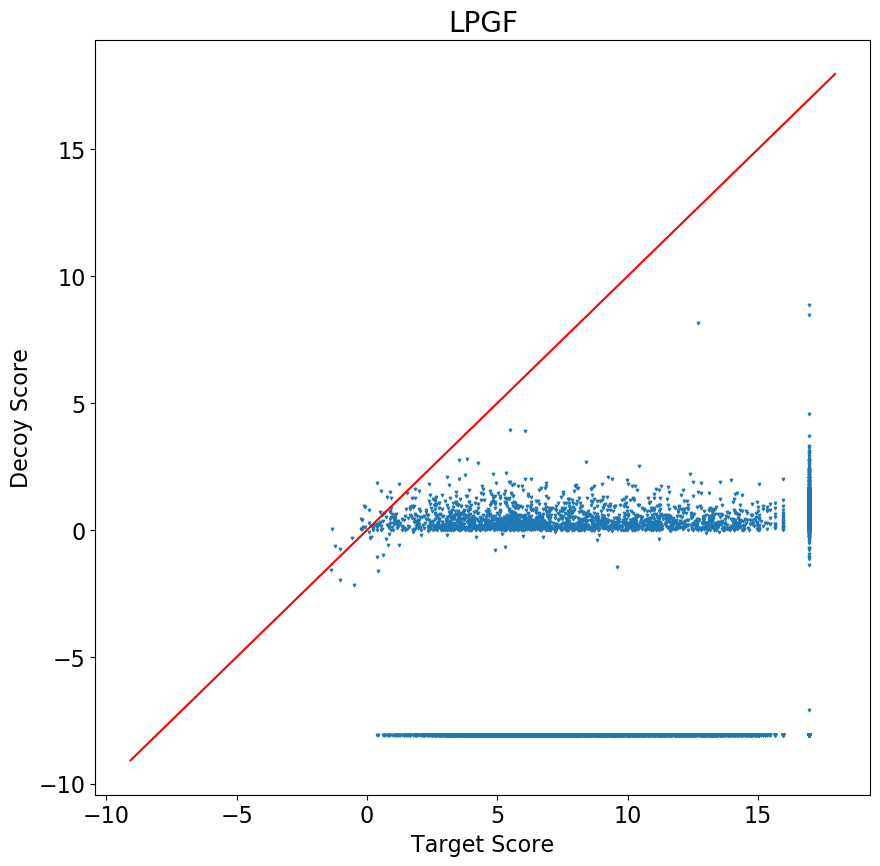

<Figure size 1000x1000 with 0 Axes>

In [6]:
plt.scatter(Target_score_rmInf_rmNA,Decoy_score_rmInf_rmNA,marker="v",s=3)
lim_upper = max(Target_score_rmInf_rmNA + Decoy_score_rmInf_rmNA)+1
lim_lower = min(Target_score_rmInf_rmNA + Decoy_score_rmInf_rmNA)-1
plt.plot([lim_lower,lim_upper],[lim_lower,lim_upper],color='red')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlim(lim_lower,lim_upper)
#plt.ylim(lim_lower,lim_upper)
plt.xlabel('Target Score',fontsize=16)
plt.ylabel('Decoy Score',fontsize=16)
plt.title('LPGF',fontsize=20)
plt.savefig('./output2/%s/tdLPGF_scatter.png'%filename)
plt.show()
plt.clf()

# Find Threshold

In [10]:
Target_score_sorted

array([-1.38375958, -1.33951041, -1.24693549, ..., 16.95458977,
       16.95458977, 16.95458977])

In [11]:
start = time.time()

Target_score_sorted = np.array(sorted(Target_score_rmInf_rmNA))
Target_score = np.array(Target_score_rmInf_rmNA) 
Decoy_score = np.array(Decoy_score_rmInf_rmNA) 

FDRr = 0
FDRr_max = 0
for ts in Target_score_sorted:
    do = sum((Target_score < ts) & (Decoy_score >= ts))
    to = sum((Target_score >= ts) & (Decoy_score < ts))
    db = sum((Target_score >= ts) & (Decoy_score >= ts) & (Decoy_score > Target_score))
    tb = sum((Target_score >= ts) & (Decoy_score >= ts) & (Decoy_score < Target_score))
    
    to_tb_db = to+tb+db
    if to_tb_db != 0:
        FDRr = (do+2*db) / to_tb_db
        if FDRr < 0.01:
            #FDRr = (do+2*db) / to_tb_db
            if FDRr >= FDRr_max:
                FDRr_max = FDRr
                Threshold = ts
                #print('FDRr=%s, Threshold=%s'%(FDRr,ts))  
            if FDRr == 0:
                break
        else:
            print('FDRr=%s'%FDRr)
            print('Threshold=%s'%ts)
            break
print('[Final Selected]')
print('Threshold=%s'%Threshold)
print('FDRr=%s'%FDRr_max)
end = time.time()
print('used %.2f sec.'%(end-start))

[Final Selected]
Threshold=-1.3395104137073182
FDRr=0.00430146070436419
used 17.36 sec.


In [19]:
qcPass = (Target_score >= Threshold) & (Target_score > Decoy_score)
do = (Target_score < Threshold) & (Decoy_score >= Threshold)
to = (Target_score >= Threshold) & (Decoy_score < Threshold)
db = (Target_score >= Threshold) & (Decoy_score >= Threshold) & (Decoy_score > Target_score)
tb = (Target_score >= Threshold) & (Decoy_score >= Threshold) & (Decoy_score < Target_score)
Not_gate = {True:False,False:True}
nt = list(map(Not_gate.get, do|to|db|tb))

In [20]:
do_dict = {True:'do',False:''}
to_dict = {True:'to',False:''}
db_dict = {True:'db',False:''}
tb_dict = {True:'tb',False:''}
nt_dict = {True:'nt',False:''}
do_ls = list(map(do_dict.get, do))
to_ls = list(map(to_dict.get, to))
db_ls = list(map(db_dict.get, db))
tb_ls = list(map(tb_dict.get, tb))
nt_ls = list(map(nt_dict.get, nt))
f1['qcPass'] = list(map(str.lower,list(map(str,qcPass))))
f1['qcType'] = list(map(''.join,zip(do_ls,to_ls,db_ls,tb_ls,nt_ls)))


In [21]:
f1.to_csv('./output2/%s/3.qcPass.csv'%filename,na_rep='NA',index=False)

# Plot Distribution of Decoy

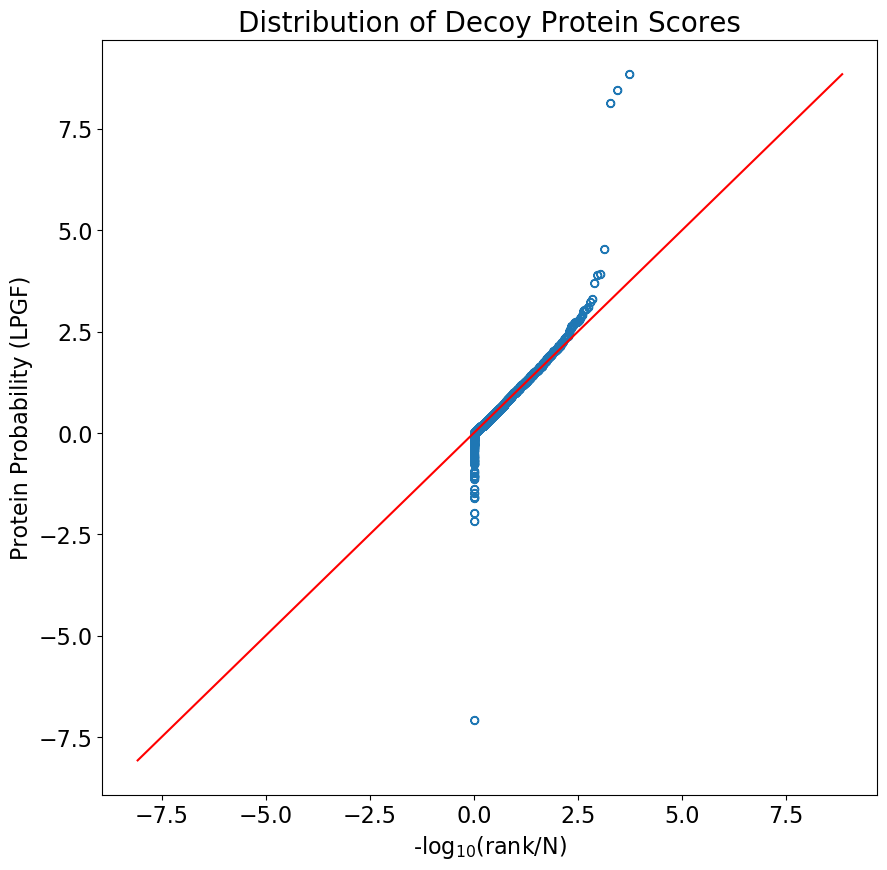

used 0.50 sec.


<Figure size 1000x1000 with 0 Axes>

In [22]:
start = time.time()
Decoy_score_rmNA = np.array(list(f1.dropna(subset=['decoy.LPGF'])['decoy.LPGF']))
N = len(Decoy_score_rmNA)
decoy_rank = -np.log10(ss.rankdata(-Decoy_score_rmNA)/N)
    
plt.scatter(decoy_rank,Decoy_score_rmNA,marker="$◯$")
lim_upper = max([max(decoy_rank),max(Decoy_score)])
lim_lower = min([min(decoy_rank),min(Decoy_score)])
plt.plot([lim_lower,lim_upper],[lim_lower,lim_upper],color='red')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlim(lim_lower,lim_upper)
#plt.ylim(lim_lower,lim_upper)
plt.xlabel('-log$_{10}$(rank/N)',fontsize=16)
plt.ylabel('Protein Probability (LPGF)',fontsize=16)
plt.title('Distribution of Decoy Protein Scores',fontsize=20)
plt.xticks
plt.savefig('./output2/%s/dLPGF_rank.png'%filename)
plt.show()
plt.clf()   

end = time.time()
print('used %.2f sec.'%(end-start))